In [ ]:
%load_ext autoreload
%autoreload 2

from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time, shutil
import tqdm

%matplotlib inline

In [ ]:
import os

# Définissez les variables d'environnement
os.environ['NUMBER_EDGES'] = '16'
os.environ['METRIC'] = 'cosine'
os.environ['NORMALIZED_LAPLACIAN'] = 'True'
os.environ['COARSENING_LEVELS'] = '0'
os.environ['DIR_DATA'] = os.path.join('data', 'rcv1')
os.environ['VAL_SIZE'] = '400'

# Lire les variables d'environnement
number_edges = int(os.getenv('NUMBER_EDGES', 16))
metric = os.getenv('METRIC', 'cosine')
normalized_laplacian = os.getenv('NORMALIZED_LAPLACIAN', 'True') == 'True'
coarsening_levels = int(os.getenv('COARSENING_LEVELS', 0))
dir_data = os.getenv('DIR_DATA', os.path.join('data', 'rcv1'))
val_size = int(os.getenv('VAL_SIZE', 400))

print(f'Number of edges: {number_edges}')
print(f'Metric: {metric}')
print(f'Normalized Laplacian: {normalized_laplacian}')
print(f'Coarsening levels: {coarsening_levels}')
print(f'Directory for data: {dir_data}')
print(f'Validation size: {val_size}')


Number of edges: 16
Metric: cosine
Normalized Laplacian: True
Coarsening levels: 0
Directory for data: data/rcv1
Validation size: 400


In [ ]:
import argparse
import os

# Define the argument parser
parser = argparse.ArgumentParser()

# Graphs.
parser.add_argument('--number_edges', type=int, default=16, help='Graph: minimum number of edges per vertex.')
parser.add_argument('--metric', type=str, default='cosine', help='Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
parser.add_argument('--normalized_laplacian', type=bool, default=True, help='Graph Laplacian: normalized.')
parser.add_argument('--coarsening_levels', type=int, default=0, help='Number of coarsened graphs.')

parser.add_argument('--dir_data', type=str, default=os.path.join('data', 'rcv1'), help='Directory to store data.')
parser.add_argument('--val_size', type=int, default=400, help='Size of the validation set.')

# Parse the arguments
FLAGS, unparsed = parser.parse_known_args()

# You can now access the arguments as FLAGS.number_edges, FLAGS.metric, etc.
print(f'number_edges: {FLAGS.number_edges}')
print(f'metric: {FLAGS.metric}')
print(f'normalized_laplacian: {FLAGS.normalized_laplacian}')
print(f'coarsening_levels: {FLAGS.coarsening_levels}')
print(f'dir_data: {FLAGS.dir_data}')
print(f'val_size: {FLAGS.val_size}')


number_edges: 16
metric: cosine
normalized_laplacian: True
coarsening_levels: 0
dir_data: data/rcv1
val_size: 400


# Data

**From Dropout (Bruna did the same).**
We took the dataset and split it into 63 classes based on the the 63 categories at the second-level of the category tree. We removed 11 categories that did not have any data and one category that had only 4 training examples. We also removed one category that covered a huge chunk (25%) of the examples. This left us with 50 classes and 402,738 documents. We divided the documents into equal-sized training and test sets randomly. Each document was represented
using the 2000 most frequent non-stopwords in the dataset.

In [ ]:


# Fetch dataset from Scikit-learn.
dataset = utils.TextRCV1(data_home=FLAGS.dir_data)

# Pre-processing: transform everything to a-z and whitespace.
#print(train.show_document(1)[:400])
#train.clean_text(num='substitute')

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
#train.vectorize(stop_words='english')
#print(train.show_document(1)[:400])

N = 804414 documents, C = 103 classes


categories (2606875 assignments in total)
categories (976994 assignments in total)
  C11  :  24325 documents
  C12  :  11944 documents
  C13  :  37410 documents
  C14  :   7410 documents
  C16  :   1920 documents
  C17  :  42155 documents
  C18  :  52817 documents
  C21  :  25403 documents
  C22  :   6119 documents
  C23  :   2625 documents
  C24  :  32153 documents
  C31  :  40509 documents
  C32  :   2084 documents
  C33  :  15332 documents
  C34  :   4835 documents
  C41  :  11355 documents
  C42  :  11878 documents
  E11  :   8568 documents
  E12  :  27100 documents
  E13  :   6603 documents
  E14  :   2177 documents
  E21  :  43130 documents
  E31  :   2415 documents
  E41  :  17035 documents
  E51  :  21280 documents
  E61  :    391 documents
  E71  :   5268 documents
  G15  :  20672 documents
  GCRIM:  32219 documents
  GDEF :   8842 documents
  GDIP :  37739 documents
  GDIS :   8657 documents
  GENT :   3801 documents
  GENV :   6261 documents
  GFAS :    313 documents
  GHEA 

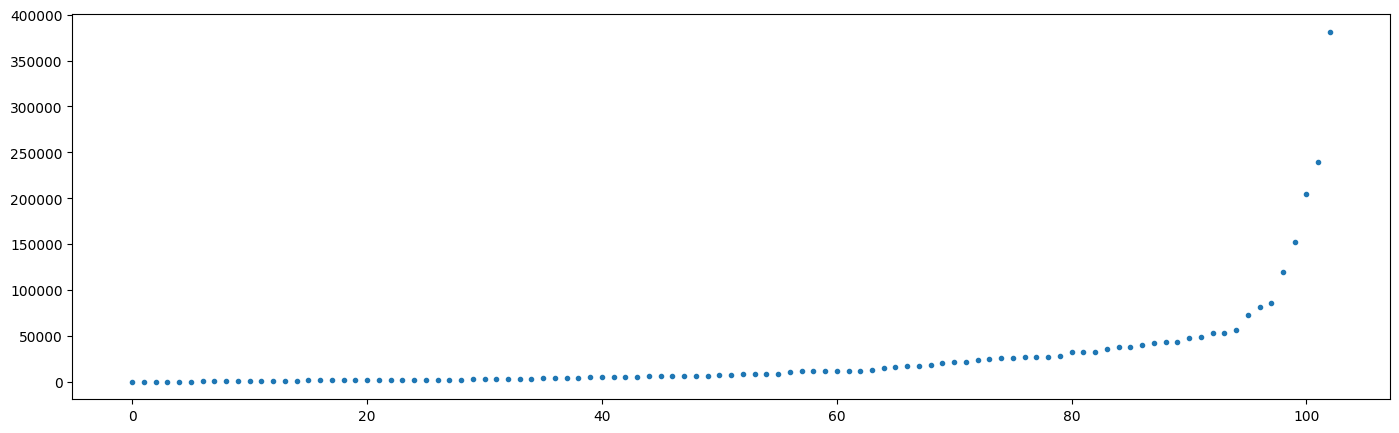

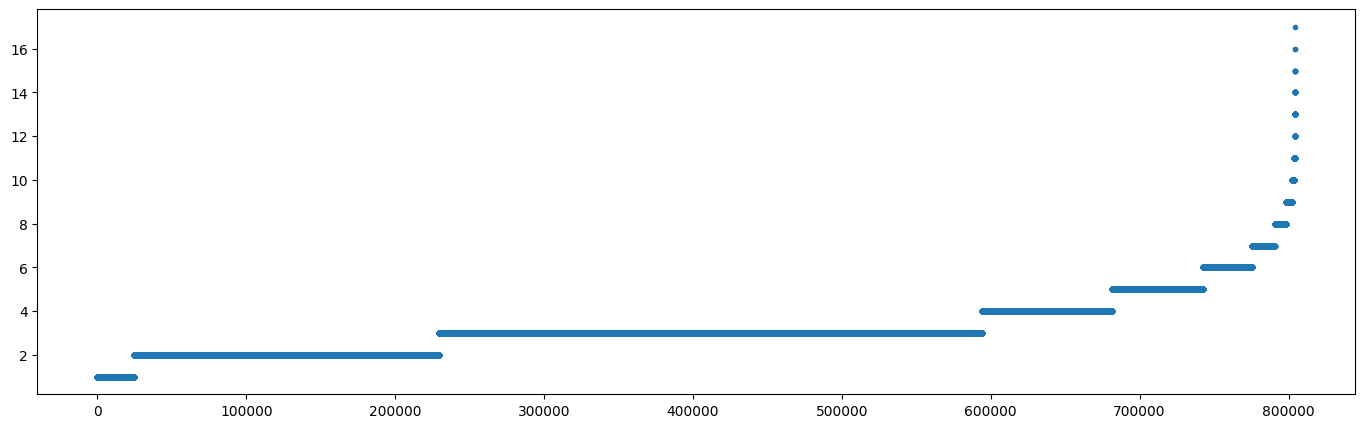

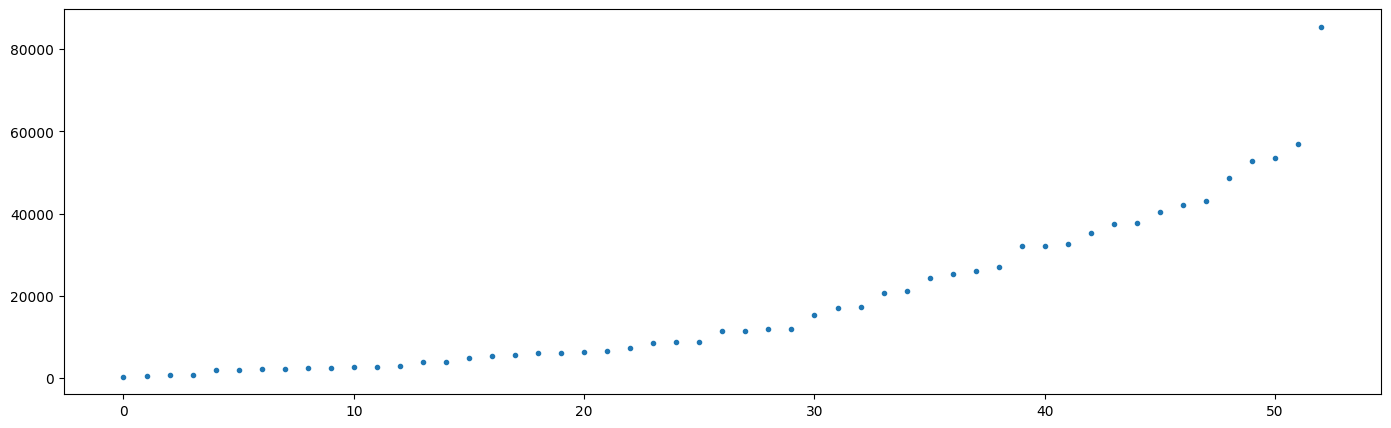

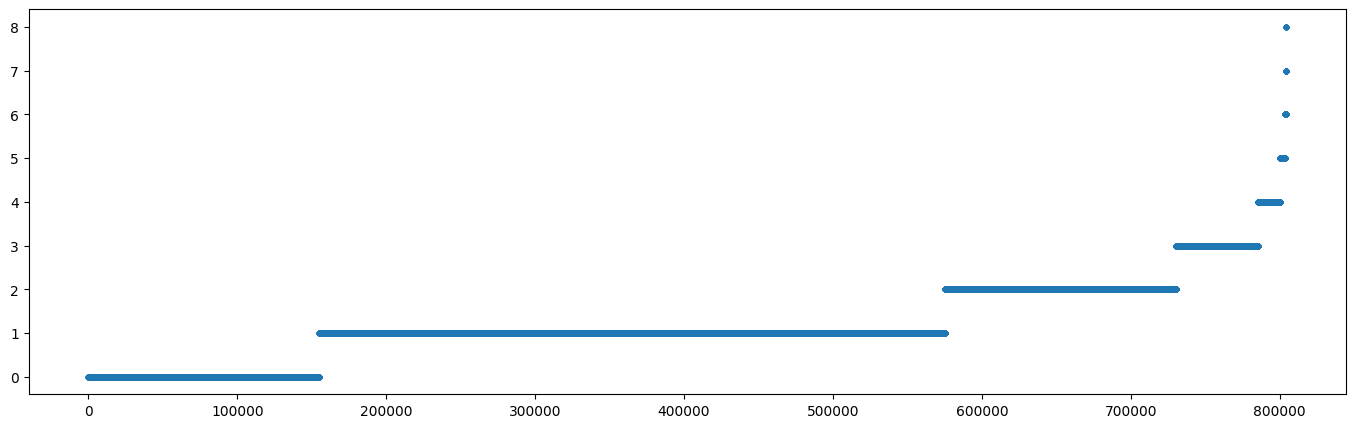

In [ ]:
# Selection of classes.
keep = ['C11','C12','C13','C14','C15','C16','C17','C18','C21','C22','C23','C24',
        'C31','C32','C33','C34','C41','C42','E11','E12','E13','E14','E21','E31',
        'E41','E51','E61','E71','G15','GCRIM','GDEF','GDIP','GDIS','GENT','GENV',
        'GFAS','GHEA','GJOB','GMIL','GOBIT','GODD','GPOL','GPRO','GREL','GSCI',
        'GSPO','GTOUR','GVIO','GVOTE','GWEA','GWELF','M11','M12','M13','M14']
assert len(keep) == 55  # There is 55 second-level categories according to LYRL2004.
keep.remove('C15')   # 151785 documents
keep.remove('GMIL')  # 5 documents only

dataset.show_doc_per_class()
dataset.show_classes_per_doc()
dataset.remove_classes(keep)
dataset.show_doc_per_class(True)
dataset.show_classes_per_doc()

In [ ]:
# Remove documents with multiple classes.
dataset.select_documents()
dataset.data_info()

N = 420065 documents, M = 47236 words, sparsity=0.1531%


In [ ]:
# Remove short documents.
#train.data_info(True)
#wc = train.remove_short_documents(nwords=20, vocab='full')
#train.data_info()
#print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
#plt.figure(figsize=(17,5))
#plt.semilogy(wc, '.');

In [ ]:
# Feature selection.
# Other options include: mutual information or document count.
#freq = train.keep_top_words(1000, 20)
#train.data_info()
#train.show_document(1)
#plt.figure(figsize=(17,5))
#plt.semilogy(freq);

# Remove documents whose signal would be the zero vector.
#wc = train.remove_short_documents(nwords=5, vocab='selected')
#train.data_info(True)

In [ ]:
#dataset.normalize(norm='l1')
dataset.show_document(1);

document 1: label 52 --> M14, N/A words


In [ ]:
# Word embedding
#if True:
#    train.embed()
#else:
#    train.embed('data_word2vec/GoogleNews-vectors-negative300.bin')
#train.data_info()
# Further feature selection. (TODO)

In [ ]:
perm = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
Ntest = dataset.data.shape[0] // 2
perm_test = perm[:Ntest]
perm_train = perm[Ntest:]
train_data = dataset.data[perm_train,:].astype(np.float32)
test_data = dataset.data[perm_test,:].astype(np.float32)
train_labels = dataset.labels[perm_train]
test_labels = dataset.labels[perm_test]

if False:
    graph_data = train.embeddings.astype(np.float32)
else:
    graph_data = dataset.data.T.astype(np.float32)

#del dataset

# Feature graph

In [ ]:
t_start = time.process_time()
dist, idx = graph.distance_lshforest(graph_data.astype(np.float64), k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist.astype(np.float32), idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

In [ ]:
assert FLAGS.coarsening_levels is 0
#t_start = time.process_time()
#train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
#test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))
#print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#del perm

<>:1: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
/tmp/ipykernel_28321/1719794191.py:1: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  assert FLAGS.coarsening_levels is 0


# Classification

In [ ]:
# Training set is shuffled already.
#perm = np.random.permutation(train_data.shape[0])
#train_data = train_data[perm,:]
#train_labels = train_labels[perm]

# Validation set.
if False:
    val_data = train_data[:FLAGS.val_size,:]
    val_labels = train_labels[:FLAGS.val_size]
    train_data = train_data[FLAGS.val_size:,:]
    train_labels = train_labels[FLAGS.val_size:]
else:
    val_data = test_data
    val_labels = test_labels

In [ ]:
if False:
    utils.baseline(train_data, train_labels, test_data, test_labels)

In [ ]:
common = {}
common['dir_name']       = 'rcv1/'
common['num_epochs']     = 4
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 200
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes

model_perf = utils.model_perf()

In [ ]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 1e3
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47236
  layer 1: logits (softmax)
    representation: M_1 = 53
    weights: M_0 * M_1 = 47236 * 53 = 2503508
    biases: M_1 = 53


2024-08-07 10:29:33.462994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 10:29:33.465248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6
2024-08-07 10:29:33.482940: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


step 200 / 8401 (epoch 0.10 / 4):
  learning_rate = 1.00e+03, loss_average = 2.26e+01
  validation accuracy: 84.32 (177103 / 210032), f1 (weighted): 84.39, loss: 2.07e+01
  time: 55s (wall 56s)
step 400 / 8401 (epoch 0.19 / 4):
  learning_rate = 1.00e+03, loss_average = 1.91e+01
  validation accuracy: 84.16 (176764 / 210032), f1 (weighted): 84.24, loss: 2.26e+01
  time: 108s (wall 111s)
step 600 / 8401 (epoch 0.29 / 4):
  learning_rate = 1.00e+03, loss_average = 1.79e+01
  validation accuracy: 85.12 (178781 / 210032), f1 (weighted): 85.51, loss: 1.85e+01
  time: 161s (wall 166s)
step 800 / 8401 (epoch 0.38 / 4):
  learning_rate = 1.00e+03, loss_average = 2.22e+01
  validation accuracy: 85.87 (180346 / 210032), f1 (weighted): 85.88, loss: 1.88e+01
  time: 213s (wall 220s)
step 1000 / 8401 (epoch 0.48 / 4):
  learning_rate = 1.00e+03, loss_average = 1.56e+01
  validation accuracy: 87.49 (183765 / 210032), f1 (weighted): 87.74, loss: 1.51e+01
  time: 266s (wall 275s)
step 1200 / 8401 (epo

2024-08-07 11:08:55.620147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 11:08:55.621560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 94.53 (198543 / 210033), f1 (weighted): 94.50, loss: 4.45e+00
time: 57s (wall 57s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/rcv1/softmax/model-8401


2024-08-07 11:09:53.056459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 11:09:53.057886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 88.32 (185510 / 210032), f1 (weighted): 88.25, loss: 1.65e+01
time: 56s (wall 57s)


In [ ]:
if True:
    name = 'fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47236
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 47236 * 2500 = 118090000
    biases: M_1 = 2500
  layer 2: logits (softmax)
    representation: M_2 = 53
    weights: M_1 * M_2 = 2500 * 53 = 132500
    biases: M_2 = 53


2024-08-07 11:10:50.566122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 11:10:50.567517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 200 / 8401 (epoch 0.10 / 4):
  learning_rate = 1.00e-01, loss_average = 8.91e-01
  validation accuracy: 80.52 (169112 / 210032), f1 (weighted): 78.40, loss: 8.64e-01
  time: 63s (wall 67s)
step 400 / 8401 (epoch 0.19 / 4):
  learning_rate = 1.00e-01, loss_average = 6.26e-01
  validation accuracy: 85.06 (178654 / 210032), f1 (weighted): 83.64, loss: 6.18e-01
  time: 132s (wall 146s)
step 600 / 8401 (epoch 0.29 / 4):
  learning_rate = 1.00e-01, loss_average = 5.50e-01
  validation accuracy: 86.00 (180632 / 210032), f1 (weighted): 84.71, loss: 5.46e-01
  time: 201s (wall 225s)
step 800 / 8401 (epoch 0.38 / 4):
  learning_rate = 1.00e-01, loss_average = 4.61e-01
  validation accuracy: 86.80 (182303 / 210032), f1 (weighted): 86.02, loss: 4.87e-01
  time: 270s (wall 305s)
step 1000 / 8401 (epoch 0.48 / 4):
  learning_rate = 1.00e-01, loss_average = 4.58e-01
  validation accuracy: 87.76 (184323 / 210032), f1 (weighted): 86.94, loss: 4.60e-01
  time: 339s (wall 383s)
step 1200 / 8401 (epo

2024-08-07 12:07:56.777502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 12:07:56.779070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 95.48 (200544 / 210033), f1 (weighted): 95.41, loss: 1.63e-01
time: 65s (wall 73s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/rcv1/fc_softmax/model-8401


2024-08-07 12:09:09.913124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 12:09:09.914520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 90.90 (190925 / 210032), f1 (weighted): 90.76, loss: 3.19e-01
time: 63s (wall 63s)


In [ ]:
if True:
    name = 'fc_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, 500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47236
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 47236 * 2500 = 118090000
    biases: M_1 = 2500
  layer 2: fc2
    representation: M_2 = 500
    weights: M_1 * M_2 = 2500 * 500 = 1250000
    biases: M_2 = 500
  layer 3: logits (softmax)
    representation: M_3 = 53
    weights: M_2 * M_3 = 500 * 53 = 26500
    biases: M_3 = 53


2024-08-07 12:10:13.634028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 12:10:13.635511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 200 / 8401 (epoch 0.10 / 4):
  learning_rate = 1.00e-01, loss_average = 6.76e-01
  validation accuracy: 82.21 (172667 / 210032), f1 (weighted): 81.14, loss: 6.61e-01
  time: 63s (wall 67s)
step 400 / 8401 (epoch 0.19 / 4):
  learning_rate = 1.00e-01, loss_average = 5.60e-01
  validation accuracy: 84.84 (178182 / 210032), f1 (weighted): 84.25, loss: 5.60e-01
  time: 132s (wall 146s)
step 600 / 8401 (epoch 0.29 / 4):
  learning_rate = 1.00e-01, loss_average = 5.42e-01
  validation accuracy: 86.64 (181969 / 210032), f1 (weighted): 86.15, loss: 4.95e-01
  time: 202s (wall 226s)
step 800 / 8401 (epoch 0.38 / 4):
  learning_rate = 1.00e-01, loss_average = 4.57e-01
  validation accuracy: 86.27 (181196 / 210032), f1 (weighted): 85.03, loss: 5.11e-01
  time: 272s (wall 306s)
step 1000 / 8401 (epoch 0.48 / 4):
  learning_rate = 1.00e-01, loss_average = 4.53e-01
  validation accuracy: 86.83 (182377 / 210032), f1 (weighted): 86.53, loss: 4.61e-01
  time: 342s (wall 386s)
step 1200 / 8401 (epo

2024-08-07 13:06:32.770859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 13:06:32.772258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 97.85 (205516 / 210033), f1 (weighted): 97.82, loss: 8.09e-02
time: 63s (wall 71s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/rcv1/fc_fc_softmax/model-8401


2024-08-07 13:07:44.054702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 13:07:44.056121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 90.27 (189592 / 210032), f1 (weighted): 90.11, loss: 3.81e-01
time: 63s (wall 64s)


In [ ]:
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [1]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47236
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 47236 * 1 / 1 = 47236
    weights: F_0 * F_1 * K_1 = 1 * 1 * 5 = 5
    biases: F_1 = 1
  layer 2: logits (softmax)
    representation: M_2 = 53
    weights: M_1 * M_2 = 47236 * 53 = 2503508
    biases: M_2 = 53


2024-08-07 13:08:56.772277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 13:08:56.773839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 200 / 8401 (epoch 0.10 / 4):
  learning_rate = 1.00e-01, loss_average = 1.27e+01
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 1.27e+01
  time: 110s (wall 115s)
step 400 / 8401 (epoch 0.19 / 4):
  learning_rate = 1.00e-01, loss_average = 1.22e+01
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 1.22e+01
  time: 210s (wall 221s)
step 600 / 8401 (epoch 0.29 / 4):
  learning_rate = 1.00e-01, loss_average = 1.18e+01
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 1.18e+01
  time: 310s (wall 326s)
step 800 / 8401 (epoch 0.38 / 4):
  learning_rate = 1.00e-01, loss_average = 1.15e+01
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 1.14e+01
  time: 409s (wall 431s)
step 1000 / 8401 (epoch 0.48 / 4):
  learning_rate = 1.00e-01, loss_average = 1.11e+01
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 1.11e+01
  time: 509s (wall 537s)
step 1200 / 8401 (epoch 0.57 

2024-08-07 14:26:19.505157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 14:26:19.506534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 15.69 (32962 / 210033), f1 (weighted): 4.26, loss: 4.91e+00
time: 104s (wall 107s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/rcv1/cgconv_softmax/model-8401


2024-08-07 14:28:06.800919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 14:28:06.802305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 4.91e+00
time: 104s (wall 106s)


In [ ]:
if True:
    name = 'cgconv_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [5]
    params['K']              = [15]
    params['p']              = [1]
    params['M']              = [100, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47236
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 47236 * 5 / 1 = 236180
    weights: F_0 * F_1 * K_1 = 1 * 5 * 15 = 75
    biases: F_1 = 5
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 236180 * 100 = 23618000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 53
    weights: M_2 * M_3 = 100 * 53 = 5300
    biases: M_3 = 53


2024-08-07 14:30:07.190108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 14:30:07.191532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 200 / 8401 (epoch 0.10 / 4):
  learning_rate = 1.00e-01, loss_average = 3.08e+00
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 3.08e+00
  time: 231s (wall 247s)
step 400 / 8401 (epoch 0.19 / 4):
  learning_rate = 1.00e-01, loss_average = 3.07e+00
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 3.06e+00
  time: 456s (wall 485s)
step 600 / 8401 (epoch 0.29 / 4):
  learning_rate = 1.00e-01, loss_average = 3.05e+00
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 3.05e+00
  time: 675s (wall 718s)
step 800 / 8401 (epoch 0.38 / 4):
  learning_rate = 1.00e-01, loss_average = 3.05e+00
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 3.05e+00
  time: 896s (wall 952s)
step 1000 / 8401 (epoch 0.48 / 4):
  learning_rate = 1.00e-01, loss_average = 3.05e+00
  validation accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 3.04e+00
  time: 1116s (wall 1186s)
step 1200 / 8401 (epoch 0.5

2024-08-07 17:22:37.515584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 17:22:37.517052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 15.69 (32962 / 210033), f1 (weighted): 4.26, loss: 3.04e+00
time: 226s (wall 226s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/rcv1/cgconv_fc_softmax/model-8401


2024-08-07 17:26:23.894152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15930 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 17:26:23.895552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39828 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 15.74 (33066 / 210032), f1 (weighted): 4.28, loss: 3.04e+00
time: 228s (wall 226s)


  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
15.74 15.69    4.28  4.26   3.04e+00 3.04e+00   1232   cgconv_fc_softmax
15.74 15.69    4.28  4.26   4.91e+00 4.91e+00   553   cgconv_softmax
90.27 97.85   90.11 97.82   3.81e-01 8.09e-02   402   fc_fc_softmax
90.90 95.48   90.76 95.41   3.19e-01 1.63e-01   408   fc_softmax
88.32 94.53   88.25 94.50   1.65e+01 4.45e+00   281   softmax


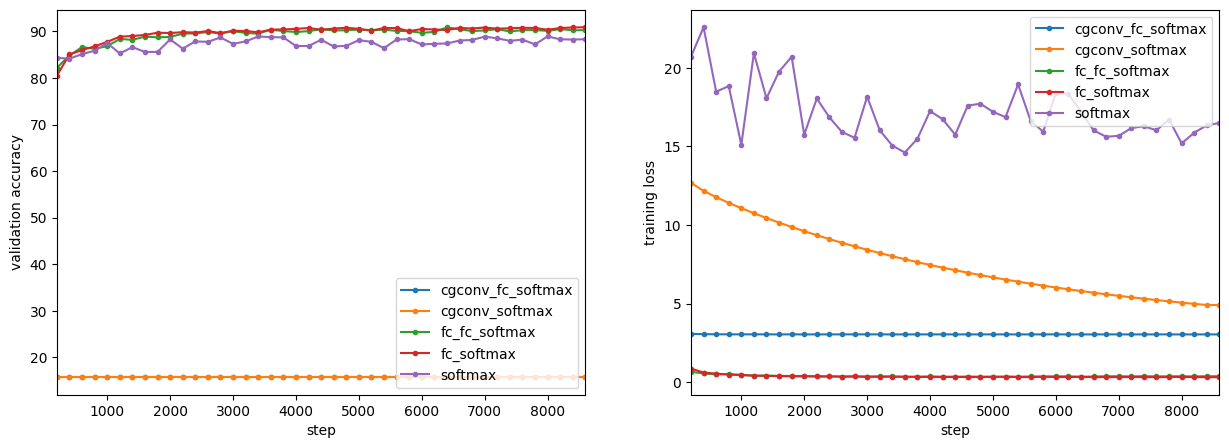

In [ ]:
model_perf.show()